# Preprocesamiento de Datos de Voz - Ibarra et al. (2023)

## Pipeline Exacto según Paper

Este notebook implementa el preprocesamiento exacto descrito en Ibarra et al. (2023):

### Pipeline (sin augmentation):
1. **Resample**: 44.1 kHz
2. **Normalización**: Por amplitud máxima absoluta
3. **Segmentación**: Ventanas de 400ms con 50% overlap
4. **Mel Spectrogram**: 65 bandas, hop 10ms, ventana FFT 40ms
5. **Conversión**: Amplitud a dB
6. **Normalización**: Z-score por espectrograma
7. **Dimensión final**: 65×41 píxeles

### Output:
- Espectrogramas individuales (65×41) guardados en cache
- Reutilizables para CNN2D y Time-CNN-LSTM
- Cache en `cache/healthy_ibarra.pkl` y `cache/parkinson_ibarra.pkl`

### Uso:
Los espectrogramas pueden usarse directamente para:
- **CNN2D**: Un espectrograma por input
- **Time-CNN-LSTM**: Secuencias de n espectrogramas con padding/masking


## 1. Setup y Configuración


In [1]:
# =============================
# BOOT: Drive (Othercomputers) + Git + Rama (pro)
# =============================
from google.colab import drive

drive.mount("/content/drive")

import os, sys, subprocess

# <<< AJUSTA ESTOS NOMBRES SI HACE FALTA >>>
COMPUTER_NAME = "ZenBook"  # tal cual aparece en Drive
PROJECT_DIR = "parkinson-voice-uncertainty"  # carpeta del repo
BRANCH = "main"  # p.ej. "dev", "feature/x"

BASE = "/content/drive/Othercomputers"
PROJ = os.path.join(BASE, COMPUTER_NAME, PROJECT_DIR)


# ── util ──────────────────────────────────────────────────────────────────────
def sh(*args, check=False):
    print("$", " ".join(args))
    res = subprocess.run(
        args, text=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT
    )
    print(res.stdout)
    if check and res.returncode != 0:
        raise RuntimeError("Command failed")
    return res.returncode


# ── comprobaciones ────────────────────────────────────────────────────────────
assert os.path.isdir(os.path.join(BASE, COMPUTER_NAME)), (
    f"No encuentro {COMPUTER_NAME} en {BASE}. Revisa el nombre exacto en Drive."
)
assert os.path.isdir(PROJ), f"No encuentro el repo en: {PROJ}"

# sys.path para imports limpios
if PROJ not in sys.path:
    sys.path.insert(0, PROJ)

# Marca repo como 'safe' para Git
sh("git", "config", "--global", "--add", "safe.directory", PROJ)

# ── asegurar rama y actualizar ────────────────────────────────────────────────
# Trae refs remotas y limpia ramas obsoletas
sh("git", "-C", PROJ, "fetch", "--all", "--prune")

# Muestra rama actual
sh("git", "-C", PROJ, "branch", "--show-current")

# Intenta checkout; si no existe local, crea desde origin/BRANCH
rc = sh("git", "-C", PROJ, "checkout", BRANCH)
if rc != 0:
    sh("git", "-C", PROJ, "checkout", "-b", BRANCH, f"origin/{BRANCH}")

# Actualiza contenido de la rama
sh("git", "-C", PROJ, "pull", "origin", BRANCH)

# ── pip desde /content (carpeta estable) ──────────────────────────────────────
req = os.path.join(PROJ, "requirements.txt")
if os.path.exists(req):
    os.chdir("/content")
    sh("python", "-m", "pip", "install", "-q", "-r", req)
os.chdir(PROJ)

# ── autoreload ────────────────────────────────────────────────────────────────
try:
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")
    print("autoreload activo.")
except Exception as e:
    print("ℹNo se activó autoreload (no es grave):", e)

print("Repo listo en:", PROJ)
sh("git", "-C", PROJ, "branch", "--show-current")


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
BRANCH = "dev"  # 👈 pon la rama deseada
PROJ = "/content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty"
!git -C "$PROJ" fetch --all --prune
!git -C "$PROJ" checkout $BRANCH || git -C "$PROJ" checkout -b $BRANCH origin/$BRANCH
!git -C "$PROJ" pull origin $BRANCH
!git -C "$PROJ" branch --show-current

In [ ]:
# ============================================================
# IMPORTS Y CONFIGURACIÓN
# ============================================================
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import librosa
import warnings
warnings.filterwarnings('ignore')

# Agregar módulos propios al path (apuntar al directorio padre)
sys.path.insert(0, str(Path.cwd().parent))

# Importar módulos propios
from modules.core import preprocessing
from modules.core.preprocessing import (
    SAMPLE_RATE, WINDOW_MS, OVERLAP, N_MELS, HOP_MS,
    FFT_WINDOW, TARGET_FRAMES,
    print_preprocessing_config
)
from modules.core.dataset import (
    process_dataset,
    process_dataset_with_checkpoint,
    process_dataset_parallel_with_checkpoint,
    to_pytorch_tensors,
    save_spectrograms_cache,
    load_spectrograms_cache
)
from modules.core.visualization import (
    visualize_audio_and_spectrograms,
)

# Configuración de matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("="*70)
print("PREPROCESAMIENTO IBARRA ET AL. (2023)")
print("="*70)
print(f"Librerías cargadas correctamente")
print(f"Librosa: {librosa.__version__}")
print("="*70)

# Mostrar configuración de preprocesamiento
print("\n")
print_preprocessing_config()
print("="*70)


PREPROCESAMIENTO IBARRA ET AL. (2023)
Librerías cargadas correctamente
Librosa: 0.11.0


⚙️ Preprocessing Configuration:
  • SAMPLE_RATE: 44100
  • WINDOW_MS: 400
  • OVERLAP: 0.5
  • N_MELS: 65
  • HOP_MS: 10
  • FFT_WINDOW: 40
  • TARGET_FRAMES: 41


## 2. Exploración de Datos Raw

Cargar y explorar los archivos de audio originales.


In [3]:
# ============================================================
# CARGAR ARCHIVOS DE AUDIO
# ============================================================

DATA_PATH_HEALTHY = "../data/svdd_processed/healthy"
DATA_PATH_PARKINSON = "../data/svdd_processed/pathological"
AUDIO_EXTENSION = "wav"

print("="*70)
print("EXPLORANDO DATOS RAW")
print("="*70)

# Cargar archivos Healthy
audio_files_healthy = list(Path(DATA_PATH_HEALTHY).glob(f"*.{AUDIO_EXTENSION}"))
print(f"\nHEALTHY:")
print(f"   Ruta: {DATA_PATH_HEALTHY}")
print(f"   Archivos: {len(audio_files_healthy)}")
if audio_files_healthy:
    print(f"   Ejemplos: {', '.join([f.name for f in audio_files_healthy[:3]])}")

# Cargar archivos Parkinson
audio_files_parkinson = list(Path(DATA_PATH_PARKINSON).glob(f"*.{AUDIO_EXTENSION}"))
print(f"\nPARKINSON:")
print(f"   Ruta: {DATA_PATH_PARKINSON}")
print(f"   Archivos: {len(audio_files_parkinson)}")
if audio_files_parkinson:
    print(f"   Ejemplos: {', '.join([f.name for f in audio_files_parkinson[:3]])}")

print(f"\nBALANCE:")
print(f"   Ratio: {len(audio_files_parkinson)} : {len(audio_files_healthy)}")
if len(audio_files_parkinson) == len(audio_files_healthy):
    print(f"   BALANCE PERFECTO (1:1)")
print("="*70)


EXPLORANDO DATOS RAW

HEALTHY:
   Ruta: ../data/svdd_processed/healthy
   Archivos: 2748
   Ejemplos: 1-a_h.wav, 1-a_l.wav, 1-a_lhl.wav

PARKINSON:
   Ruta: ../data/svdd_processed/pathological
   Archivos: 5412
   Ejemplos: 101-a_h.wav, 101-a_l.wav, 101-a_lhl.wav

BALANCE:
   Ratio: 5412 : 2748


## 3. Visualización de Audio Raw

Visualizar ejemplos de audio sin procesar.


VISUALIZACIÓN DE AUDIO RAW


Healthy: 1-a_h.wav
   • Duración: 1.99s
   • Sample rate: 44100 Hz
   • Samples: 87,915

Parkinson: 101-a_h.wav
   • Duración: 1.98s
   • Sample rate: 44100 Hz
   • Samples: 87,221


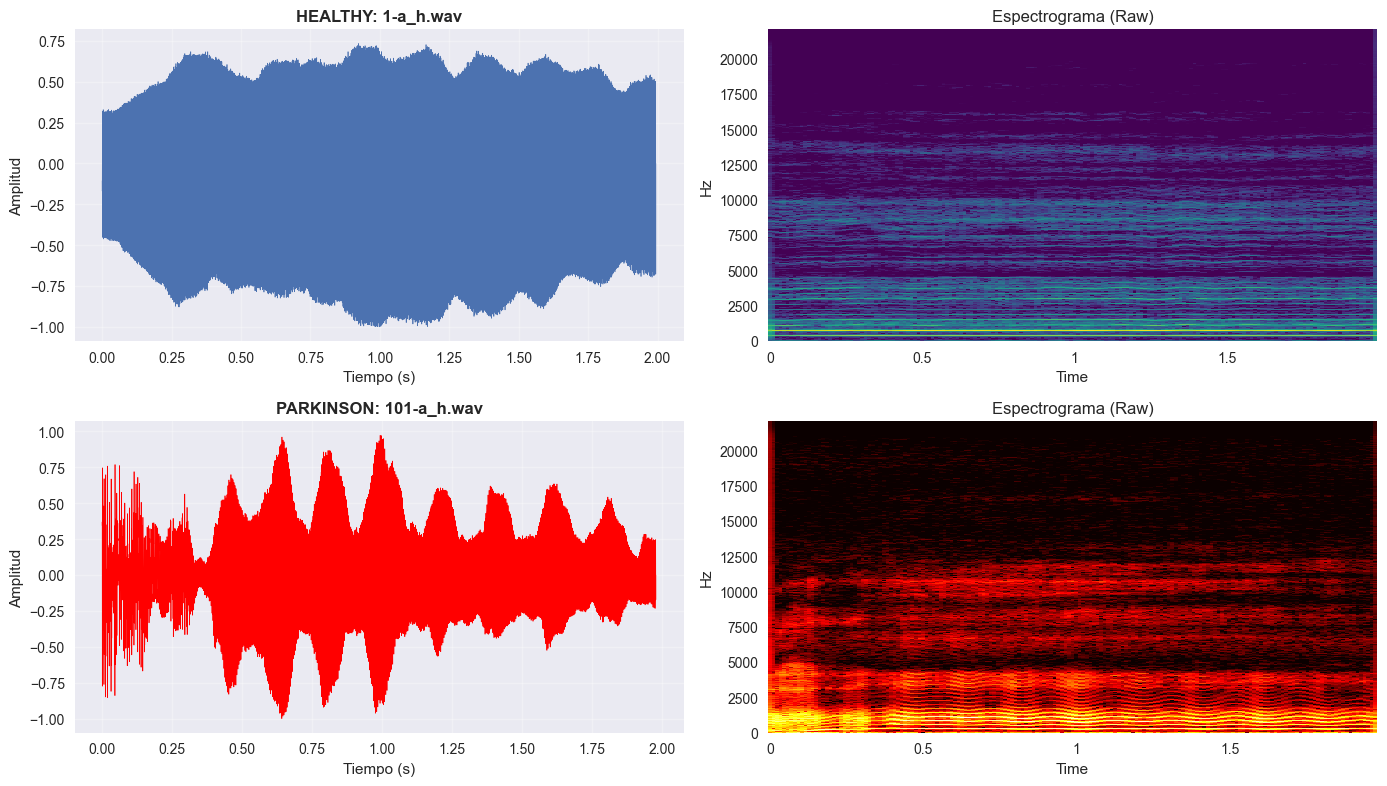

In [4]:
# ============================================================
# VISUALIZAR AUDIO ORIGINAL (SIN PROCESAMIENTO)
# ============================================================

print("="*70)
print("VISUALIZACIÓN DE AUDIO RAW")
print("="*70)

# Seleccionar un ejemplo de cada clase
example_healthy = audio_files_healthy[0] if audio_files_healthy else None
example_parkinson = audio_files_parkinson[0] if audio_files_parkinson else None

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Visualizar Healthy
if example_healthy:
    y_hc, sr_hc = librosa.load(example_healthy, sr=None)
    
    # Waveform
    axes[0, 0].plot(np.arange(len(y_hc)) / sr_hc, y_hc, linewidth=0.5)
    axes[0, 0].set_title(f"HEALTHY: {example_healthy.name}", fontweight='bold')
    axes[0, 0].set_xlabel("Tiempo (s)")
    axes[0, 0].set_ylabel("Amplitud")
    axes[0, 0].grid(alpha=0.3)
    
    # Espectrograma
    D_hc = librosa.amplitude_to_db(np.abs(librosa.stft(y_hc)), ref=np.max)
    librosa.display.specshow(D_hc, sr=sr_hc, x_axis='time', y_axis='hz', ax=axes[0, 1], cmap='viridis')
    axes[0, 1].set_title("Espectrograma (Raw)")
    
    print(f"Healthy: {example_healthy.name}")
    print(f"   • Duración: {len(y_hc)/sr_hc:.2f}s")
    print(f"   • Sample rate: {sr_hc} Hz")
    print(f"   • Samples: {len(y_hc):,}")

# Visualizar Parkinson
if example_parkinson:
    y_pd, sr_pd = librosa.load(example_parkinson, sr=None)
    
    # Waveform
    axes[1, 0].plot(np.arange(len(y_pd)) / sr_pd, y_pd, linewidth=0.5, color='red')
    axes[1, 0].set_title(f"PARKINSON: {example_parkinson.name}", fontweight='bold')
    axes[1, 0].set_xlabel("Tiempo (s)")
    axes[1, 0].set_ylabel("Amplitud")
    axes[1, 0].grid(alpha=0.3)
    
    # Espectrograma
    D_pd = librosa.amplitude_to_db(np.abs(librosa.stft(y_pd)), ref=np.max)
    librosa.display.specshow(D_pd, sr=sr_pd, x_axis='time', y_axis='hz', ax=axes[1, 1], cmap='hot')
    axes[1, 1].set_title("Espectrograma (Raw)")
    
    print(f"\nParkinson: {example_parkinson.name}")
    print(f"   • Duración: {len(y_pd)/sr_pd:.2f}s")
    print(f"   • Sample rate: {sr_pd} Hz")
    print(f"   • Samples: {len(y_pd):,}")

plt.tight_layout()
plt.show()

print("="*70)


## 4. Preprocesamiento Básico

Procesar algunos archivos para ver el pipeline de preprocesamiento.


In [5]:
# ============================================================
# PROCESAMIENTO SEGÚN IBARRA ET AL. (2023)
# ============================================================

print("="*70)
print("PREPROCESAMIENTO BÁSICO (PAPER)")
print("="*70)
print(f"\nPipeline exacto:")
print(f"   1. Resample a {SAMPLE_RATE} Hz")
print(f"   2. Normalización por amplitud máxima absoluta")
print(f"   3. Segmentación: ventanas {WINDOW_MS}ms, overlap {OVERLAP*100:.0f}%")
print(f"   4. Mel spectrogram: {N_MELS} bandas, ventana FFT {FFT_WINDOW}ms, hop {HOP_MS}ms")
print(f"   5. Conversión a dB")
print(f"   6. Normalización z-score por espectrograma")
print(f"   7. Shape final: {N_MELS}×{TARGET_FRAMES}")

# Procesar Healthy (muestra pequeña para visualización)
print(f"\nProcesando HEALTHY (primeros 3 archivos)...")
dataset_healthy = process_dataset(
    audio_files=audio_files_healthy[:3],
    preprocess_fn=preprocessing.preprocess_audio_paper,
    max_files=None
)

X_healthy_preview, y_task_healthy_preview, y_domain_healthy_preview, meta_healthy_preview = to_pytorch_tensors(dataset_healthy)

print(f"\n   Healthy procesado:")
print(f"      • Archivos: 3")
print(f"      • Espectrogramas generados: {len(dataset_healthy)}")
print(f"      • Shape tensores: {X_healthy_preview.shape}")

# Procesar Parkinson (muestra pequeña)
print(f"\nProcesando PARKINSON (primeros 3 archivos)...")
dataset_parkinson = process_dataset(
    audio_files=audio_files_parkinson[:3],
    preprocess_fn=preprocessing.preprocess_audio_paper,
    max_files=None
)

X_parkinson_preview, y_task_parkinson_preview, y_domain_parkinson_preview, meta_parkinson_preview = to_pytorch_tensors(dataset_parkinson)

print(f"\n   Parkinson procesado:")
print(f"      • Archivos: 3")
print(f"      • Espectrogramas generados: {len(dataset_parkinson)}")
print(f"      • Shape tensores: {X_parkinson_preview.shape}")

print("="*70)


PREPROCESAMIENTO BÁSICO (PAPER)

Pipeline exacto:
   1. Resample a 44100 Hz
   2. Normalización por amplitud máxima absoluta
   3. Segmentación: ventanas 400ms, overlap 50%
   4. Mel spectrogram: 65 bandas, ventana FFT 40ms, hop 10ms
   5. Conversión a dB
   6. Normalización z-score por espectrograma
   7. Shape final: 65×41

Procesando HEALTHY (primeros 3 archivos)...
🔄 Procesando 3 archivos...
📊 Configuración: progress_every=10
  📁 1/3 (33.3%) - 1-a_h.wav
     ✅ Procesados: 1 | ⏳ Faltan: 2

📊 RESUMEN DEL PROCESAMIENTO
📁 Archivos totales: 3
✅ Archivos exitosos: 3
❌ Archivos fallidos: 0
📈 Tasa de éxito: 100.0%
🎯 Muestras generadas: 22
📊 Promedio muestras/archivo: 7.3
PyTorch tensors listos:
  - X: (22, 1, 65, 41)
  - y_task: (22,)  (dist={0: 22})
  - y_domain: (22,)  (K dominios=3)

   Healthy procesado:
      • Archivos: 3
      • Espectrogramas generados: 22
      • Shape tensores: torch.Size([22, 1, 65, 41])

Procesando PARKINSON (primeros 3 archivos)...
🔄 Procesando 3 archivos...
📊

## 5. Visualización de Espectrogramas Procesados

Ver cómo se ven los Mel spectrograms después del preprocesamiento.


VISUALIZACIÓN DE MEL SPECTROGRAMS

Visualizando muestras de HEALTHY:


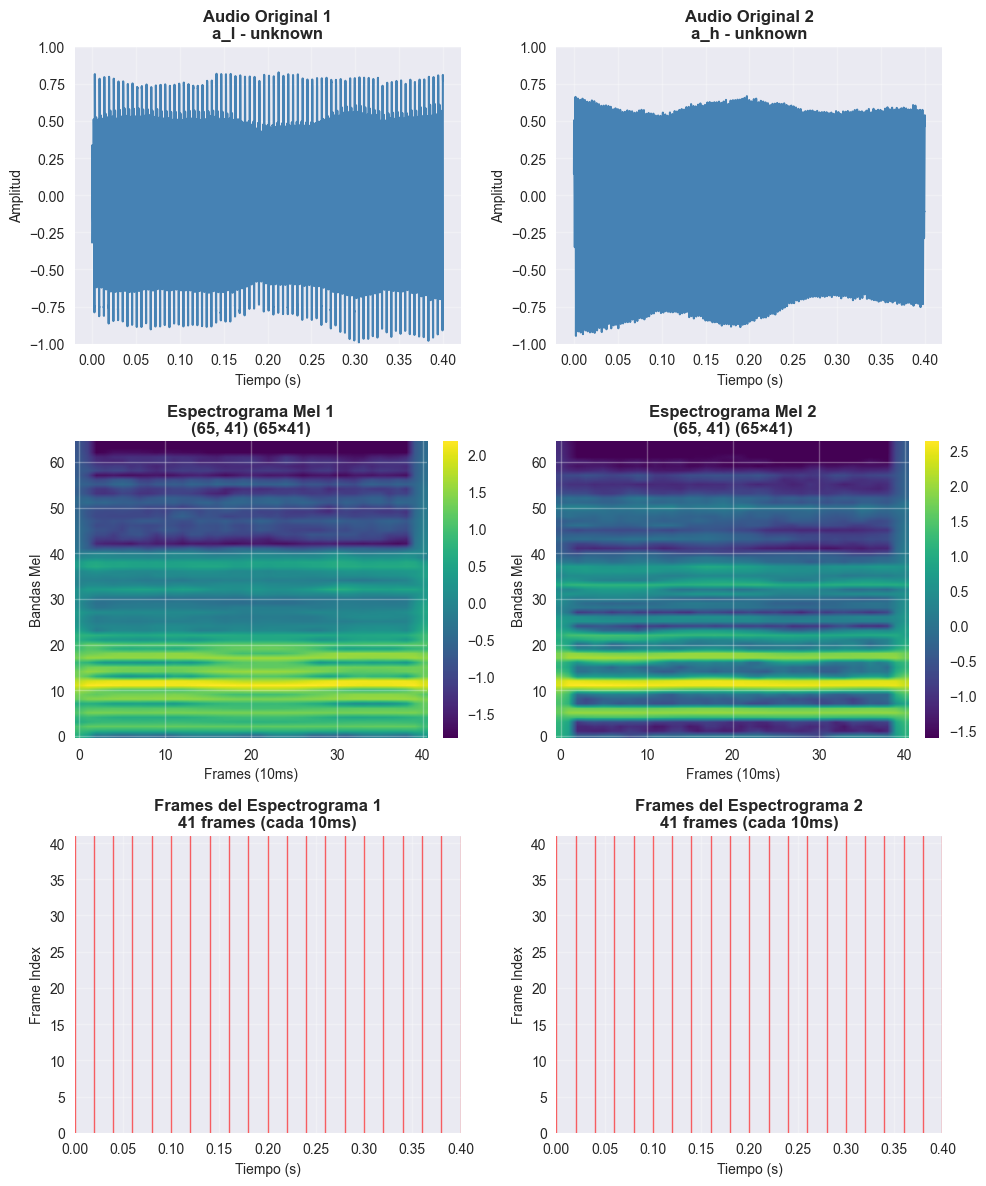


📊 INFORMACIÓN DEL PROCESAMIENTO:
  - Audio original: 0.40s (400ms por segmento)
  - Espectrograma: 65×41 (65 bandas × 41 frames)
  - Frames temporales: 41 (cada 10ms)
  - Ventana FFT: 25ms para vocal a_h
  - Normalización: z-score aplicada
Visualización Healthy completada

Visualizando muestras de PARKINSON:


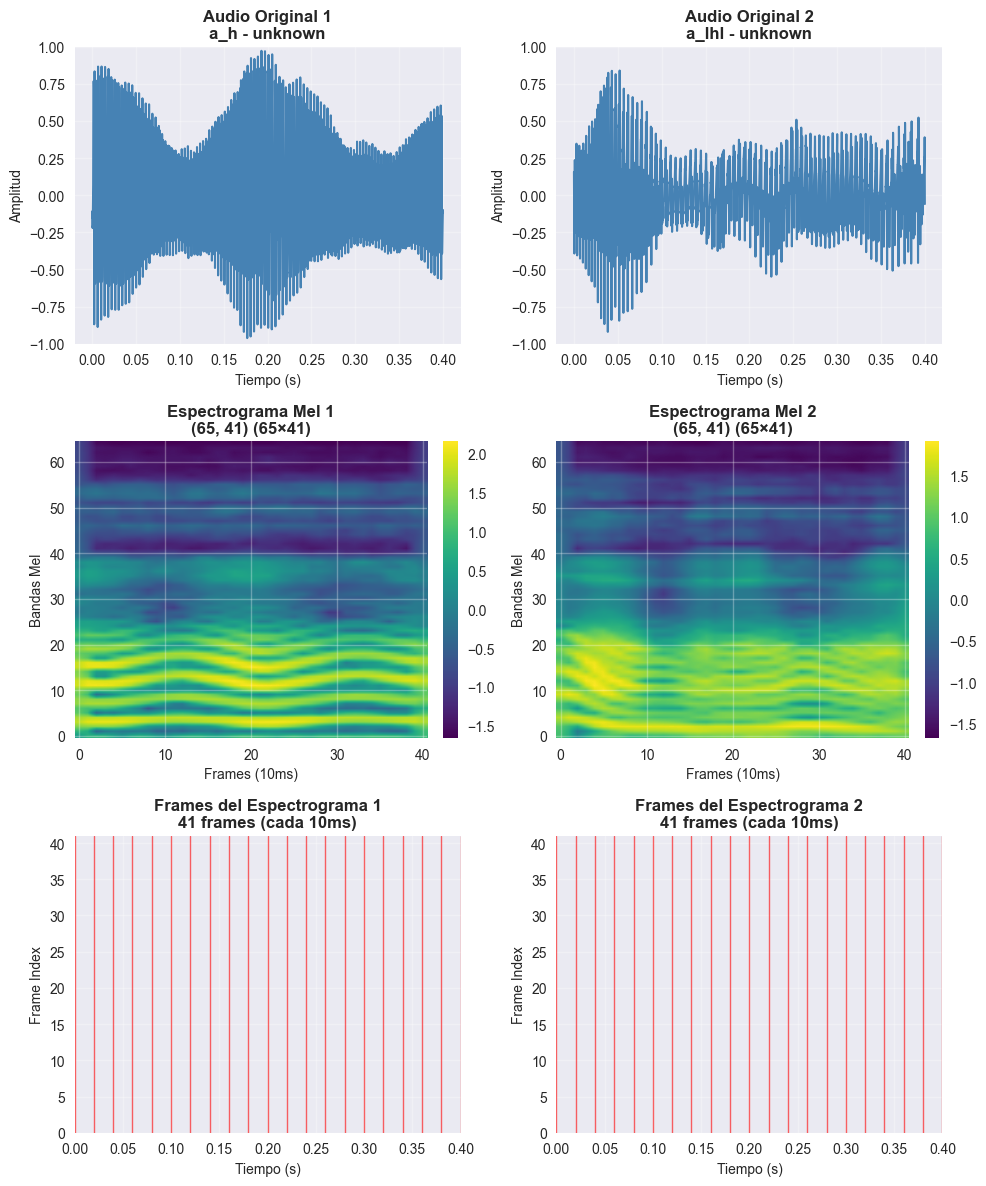


📊 INFORMACIÓN DEL PROCESAMIENTO:
  - Audio original: 0.40s (400ms por segmento)
  - Espectrograma: 65×41 (65 bandas × 41 frames)
  - Frames temporales: 41 (cada 10ms)
  - Ventana FFT: 25ms para vocal a_lhl
  - Normalización: z-score aplicada
Visualización Parkinson completada

Observa las diferencias en patrones entre Healthy y Parkinson


In [6]:
# ============================================================
# VISUALIZAR ESPECTROGRAMAS PROCESADOS
# ============================================================

print("="*70)
print("VISUALIZACIÓN DE MEL SPECTROGRAMS")
print("="*70)

# Visualizar muestras de Healthy
if dataset_healthy and len(dataset_healthy) > 0:
    print("\nVisualizando muestras de HEALTHY:")
    fig_healthy, audios_healthy = visualize_audio_and_spectrograms(
        dataset_healthy,
        num_samples=2,
        sr=SAMPLE_RATE,
        show=True,
        play_audio=False
    )
    print("Visualización Healthy completada")

# Visualizar muestras de Parkinson
if dataset_parkinson and len(dataset_parkinson) > 0:
    print("\nVisualizando muestras de PARKINSON:")
    fig_parkinson, audios_parkinson = visualize_audio_and_spectrograms(
        dataset_parkinson,
        num_samples=2,
        sr=SAMPLE_RATE,
        show=True,
        play_audio=False
    )
    print("Visualización Parkinson completada")

print("\n" + "="*70)
print("Observa las diferencias en patrones entre Healthy y Parkinson")
print("="*70)


## 6. Procesamiento Completo de Datos

Procesar TODOS los archivos y guardar en cache para reutilización.


In [7]:
# ============================================================
# CONFIGURACIÓN DE CACHE
# ============================================================

CACHE_DIR = "./cache"
CACHE_ORIGINAL_DIR = f"{CACHE_DIR}/original"
CACHE_HEALTHY = f"{CACHE_ORIGINAL_DIR}/healthy_ibarra.pkl"
CACHE_PARKINSON = f"{CACHE_ORIGINAL_DIR}/parkinson_ibarra.pkl"

# Crear directorio de cache si no existe
Path(CACHE_ORIGINAL_DIR).mkdir(parents=True, exist_ok=True)

print("="*70)
print("CONFIGURACIÓN DE CACHE")
print("="*70)
print(f"\nDirectorios de cache:")
print(f"   • Healthy: {CACHE_HEALTHY}")
print(f"   • Parkinson: {CACHE_PARKINSON}")
print(f"\n📁 Nueva estructura organizada:")
print(f"   • Datos originales: {CACHE_ORIGINAL_DIR}/")
print(f"   • Datos augmentados: {CACHE_DIR}/augmented/")
print(f"   • Secuencias LSTM: {CACHE_DIR}/sequences/")
print("\nLos espectrogramas individuales (65×41) serán guardados y")
print("   reutilizados para CNN2D y Time-CNN-LSTM.")
print("="*70)


CONFIGURACIÓN DE CACHE

Directorios de cache:
   • Healthy: ./cache/original/healthy_ibarra.pkl
   • Parkinson: ./cache/original/parkinson_ibarra.pkl

📁 Nueva estructura organizada:
   • Datos originales: ./cache/original/
   • Datos augmentados: ./cache/augmented/
   • Secuencias LSTM: ./cache/sequences/

Los espectrogramas individuales (65×41) serán guardados y
   reutilizados para CNN2D y Time-CNN-LSTM.


## 6. Sistema de Checkpoint/Resume + Multiprocessing

### 🚀 **Multiprocessing:**
- **Procesamiento paralelo** usando todos los núcleos de CPU disponibles
- **Aceleración significativa** del procesamiento (3-8x más rápido)
- **Auto-detección** del número óptimo de workers
- **Progreso en tiempo real** con velocidad y ETA

### 💾 **Sistema de Checkpoint:**
- **Continuar desde donde se quedó** si el procesamiento se interrumpe
- **Evitar reprocesar archivos** ya completados
- **Guardar progreso automáticamente** cada N archivos
- **Reiniciar desde cero** si es necesario

### ⚙️ **Configuración:**
- `n_workers=None`: Auto-detecta número de CPUs
- `force_restart=False`: Continúa desde checkpoint si existe
- `force_restart=True`: Ignora checkpoint y comienza desde cero
- Los checkpoints se guardan en `./cache/checkpoints/`


## 7. Procesar Healthy - Todos los archivos


In [ ]:
# ============================================================
# PROCESAR HEALTHY - TODOS LOS ARCHIVOS (CON CHECKPOINT)
# ============================================================

print("\n" + "="*70)
print("PROCESANDO HEALTHY - TODOS LOS ARCHIVOS")
print("="*70)

# Configuración de checkpoints
CHECKPOINT_HEALTHY = "./cache/checkpoints/healthy_checkpoint.pkl"

# Intentar cargar desde cache
dataset_healthy_full = load_spectrograms_cache(CACHE_HEALTHY)

if dataset_healthy_full is None:
    print("\nCache no encontrado. Procesando archivos...")
    print("💾 Sistema de checkpoint activado - puedes interrumpir y continuar después")
    
    # Procesar todos los archivos healthy con checkpoint y multiprocessing
    dataset_healthy_full = process_dataset_parallel_with_checkpoint(
        audio_files=audio_files_healthy,
        checkpoint_path=CHECKPOINT_HEALTHY,
        preprocess_fn=preprocessing.preprocess_audio_paper,
        progress_every=3,
        force_restart=False,  # Cambiar a True para comenzar desde cero
        n_workers=None,  # Auto-detecta número de CPUs
        chunk_size=1
    )
    
    # Guardar en cache
    save_spectrograms_cache(dataset_healthy_full, CACHE_HEALTHY)
else:
    print("Datos cargados desde cache")

# Convertir a tensores
X_healthy, y_task_healthy, y_domain_healthy, meta_healthy = to_pytorch_tensors(dataset_healthy_full)

print(f"\nHEALTHY COMPLETADO:")
print(f"   • Archivos originales: {len(audio_files_healthy)}")
print(f"   • Espectrogramas generados: {len(dataset_healthy_full)}")
print(f"   • Shape: {X_healthy.shape}")
print(f"   • Espectrogramas por archivo (promedio): {len(dataset_healthy_full)/len(audio_files_healthy):.1f}")
print("="*70)



PROCESANDO HEALTHY - TODOS LOS ARCHIVOS

Cache no encontrado. Procesando archivos...
💾 Sistema de checkpoint activado - puedes interrumpir y continuar después
🔄 Procesando 2748 archivos...
📊 Configuración: progress_every=3
  📁 1/2748 (0.0%) - 1-a_h.wav
     ✅ Procesados: 1 | ⏳ Faltan: 2747



💾 Checkpoint guardado: ./cache/checkpoints/healthy_checkpoint.pkl
   Tamaño: 1.7 MB
   Archivos procesados: 3/2748
   Muestras en dataset: 22
  📁 4/2748 (0.1%) - 1-a_n.wav
     ✅ Procesados: 4 | ⏳ Faltan: 2744

💾 Checkpoint guardado: ./cache/checkpoints/healthy_checkpoint.pkl
   Tamaño: 3.3 MB
   Archivos procesados: 6/2748
   Muestras en dataset: 43
  📁 7/2748 (0.3%) - 10-a_lhl.wav
     ✅ Procesados: 7 | ⏳ Faltan: 2741

💾 Checkpoint guardado: ./cache/checkpoints/healthy_checkpoint.pkl
   Tamaño: 4.8 MB
   Archivos procesados: 9/2748
   Muestras en dataset: 62
  📁 10/2748 (0.4%) - 100-a_l.wav
     ✅ Procesados: 10 | ⏳ Faltan: 2738

💾 Checkpoint guardado: ./cache/checkpoints/healthy_checkpoint.pkl
   Tamaño: 5.7 MB
   Archivos procesados: 12/2748
   Muestras en dataset: 74
  📁 13/2748 (0.5%) - 1000-a_h.wav
     ✅ Procesados: 13 | ⏳ Faltan: 2735

💾 Checkpoint guardado: ./cache/checkpoints/healthy_checkpoint.pkl
   Tamaño: 6.4 MB
   Archivos procesados: 15/2748
   Muestras en dataset: 83

## 8. Procesar Parkinson - Todos los archivos


In [ ]:
# ============================================================
# PROCESAR PARKINSON - TODOS LOS ARCHIVOS (CON CHECKPOINT)
# ============================================================

print("\n" + "="*70)
print("PROCESANDO PARKINSON - TODOS LOS ARCHIVOS")
print("="*70)

# Configuración de checkpoints
CHECKPOINT_PARKINSON = "./cache/checkpoints/parkinson_checkpoint.pkl"

# Intentar cargar desde cache
dataset_parkinson_full = load_spectrograms_cache(CACHE_PARKINSON)

if dataset_parkinson_full is None:
    print("\nCache no encontrado. Procesando archivos...")
    print("💾 Sistema de checkpoint activado - puedes interrumpir y continuar después")
    
    # Procesar todos los archivos parkinson con checkpoint y multiprocessing
    dataset_parkinson_full = process_dataset_parallel_with_checkpoint(
        audio_files=audio_files_parkinson,
        checkpoint_path=CHECKPOINT_PARKINSON,
        preprocess_fn=preprocessing.preprocess_audio_paper,
        progress_every=3,
        force_restart=False,  # Cambiar a True para comenzar desde cero
        n_workers=None,  # Auto-detecta número de CPUs
        chunk_size=1
    )
    
    # Guardar en cache
    save_spectrograms_cache(dataset_parkinson_full, CACHE_PARKINSON)
else:
    print("Datos cargados desde cache")

# Convertir a tensores
X_parkinson, y_task_parkinson, y_domain_parkinson, meta_parkinson = to_pytorch_tensors(dataset_parkinson_full)

print(f"\nPARKINSON COMPLETADO:")
print(f"   • Archivos originales: {len(audio_files_parkinson)}")
print(f"   • Espectrogramas generados: {len(dataset_parkinson_full)}")
print(f"   • Shape: {X_parkinson.shape}")
print(f"   • Espectrogramas por archivo (promedio): {len(dataset_parkinson_full)/len(audio_files_parkinson):.1f}")
print("="*70)



PROCESANDO PARKINSON - TODOS LOS ARCHIVOS
✅ Cache cargado: ./cache/original/parkinson_ibarra.pkl
   Tamaño: 9.4 MB
   Muestras: 121
Datos cargados desde cache
📊 PyTorch tensors listos:
  - X: (121, 1, 65, 41)
  - y_task: (121,)  (dist={0: 121})
  - y_domain: (121,)  (K dominios=13)

PARKINSON COMPLETADO:
   • Archivos originales: 13
   • Espectrogramas generados: 121
   • Shape: torch.Size([121, 1, 65, 41])
   • Espectrogramas por archivo (promedio): 9.3


In [ ]:
# ============================================================
# RESUMEN DEL PREPROCESAMIENTO
# ============================================================

print("\n" + "="*70)
print("RESUMEN DE PREPROCESAMIENTO")
print("="*70)

print(f"\n🎯 DATOS GENERADOS:")
print(f"   🟢 Healthy:   {X_healthy.shape[0]:4d} espectrogramas | Shape: {tuple(X_healthy.shape[1:])}")
print(f"   🔴 Parkinson: {X_parkinson.shape[0]:4d} espectrogramas | Shape: {tuple(X_parkinson.shape[1:])}")
print(f"   📊 Total:     {X_healthy.shape[0] + X_parkinson.shape[0]:4d} espectrogramas")

balance_pct = X_parkinson.shape[0] / (X_healthy.shape[0] + X_parkinson.shape[0]) * 100
print(f"\n📈 BALANCE:")
print(f"   • Parkinson: {balance_pct:.1f}%")
print(f"   • Healthy: {100-balance_pct:.1f}%")

print(f"\n💾 CACHE GUARDADO:")
print(f"   • {CACHE_HEALTHY}")
print(f"   • {CACHE_PARKINSON}")

print(f"\n✅ Pipeline completado según Ibarra et al. (2023)")
print(f"   • Sin augmentation")
print(f"   • Normalización por max-abs + z-score individual")
print(f"   • Espectrogramas reutilizables para CNN2D y Time-CNN-LSTM")
print("="*70)



RESUMEN DE PREPROCESAMIENTO

🎯 DATOS GENERADOS:
   🟢 Healthy:    155 espectrogramas | Shape: (1, 65, 41)
   🔴 Parkinson:  121 espectrogramas | Shape: (1, 65, 41)
   📊 Total:      276 espectrogramas

📈 BALANCE:
   • Parkinson: 43.8%
   • Healthy: 56.2%

💾 CACHE GUARDADO:
   • ./cache/original/healthy_ibarra.pkl
   • ./cache/original/parkinson_ibarra.pkl

✅ Pipeline completado según Ibarra et al. (2023)
   • Sin augmentation
   • Normalización por max-abs + z-score individual
   • Espectrogramas reutilizables para CNN2D y Time-CNN-LSTM


## 9. Fin del Preprocesamiento

Los datos están listos para entrenar modelos. Para aplicar augmentation, ejecutar el notebook `data_augmentation.ipynb`.
